In [1]:
!pip install imbalanced-learn
!pip install xgboost

In [2]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder # use OneHotEncoder instead of LabelEncoder since there is no order or distance between categories
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer # lets you apply different processing steps to different columns in a single pipeline
# Its purpose is to handle mixed data types (numeric, categorical, text) without mannually splitting the dataset

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

In [3]:
# Download latest version
path = kagglehub.dataset_download("y0ussefkandil/bmw-sales2010-2024")

print(os.listdir(path))

['BMW sales data (2010-2024).csv']


In [4]:
# pick the CSV in the folder
csvs = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
assert csvs, "No CSV found in the dataset folder."
file_path = os.path.join(path, csvs[0])           # or use the exact name seen above
print("Loading:", file_path)

Loading: /kaggle/input/bmw-sales2010-2024/BMW sales data (2010-2024).csv


In [5]:
bmw_df = pd.read_csv(file_path)
bmw_df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [6]:
bmw_df.columns = bmw_df.columns.str.lower()
bmw_df.head()

,model,year,region,color,fuel_type,transmission,engine_size_l,mileage_km,price_usd,sales_volume,sales_classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [7]:
bmw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 50000 non-null  object 
 1   year                  50000 non-null  int64  
 2   region                50000 non-null  object 
 3   color                 50000 non-null  object 
 4   fuel_type             50000 non-null  object 
 5   transmission          50000 non-null  object 
 6   engine_size_l         50000 non-null  float64
 7   mileage_km            50000 non-null  int64  
 8   price_usd             50000 non-null  int64  
 9   sales_volume          50000 non-null  int64  
 10  sales_classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


In [8]:
bmw_df['sales_classification'].value_counts()

,count
sales_classification,
Low,34754
High,15246


In [9]:
# There is class imbalance for the target column (sales_classification):
# Low: 34,754 (69%)
# High: 15,246 (31%)
# Which would create misleading accuracy and model bias
# Fixes:
# Class weights (e.g., class_weight="balanced" in Logistic Regression or Random Forest).
# Oversampling “High” (SMOTE, Random Oversampling).
# Undersampling “Low.”
# Threshold tuning (adjust probability cutoff).

In [10]:
bmw_df.describe()

,year,engine_size_l,mileage_km,price_usd,sales_volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


In [11]:
for col in bmw_df.columns:
    if bmw_df[col].dtypes == 'object':
      print(col, bmw_df[col].value_counts())

model model
7 Series    4666
i3          4618
i8          4606
3 Series    4595
5 Series    4592
X1          4570
X3          4497
X5          4487
M5          4478
X6          4478
M3          4413
Name: count, dtype: int64
region region
Asia             8454
Middle East      8373
North America    8335
Europe           8334
Africa           8253
South America    8251
Name: count, dtype: int64
color color
Red       8463
Silver    8350
Grey      8348
White     8304
Black     8273
Blue      8262
Name: count, dtype: int64
fuel_type fuel_type
Hybrid      12716
Petrol      12550
Electric    12471
Diesel      12263
Name: count, dtype: int64
transmission transmission
Manual       25154
Automatic    24846
Name: count, dtype: int64
sales_classification sales_classification
Low     34754
High    15246
Name: count, dtype: int64


In [12]:
# Define target and features (exclude leakage)
target = 'sales_classification'
leak_cols = ['sales_volume'] # A leak column is a feature that contains direct or indirect information about the target that wouldn’t be available at prediction time.
feature_cols = [col for col in bmw_df.columns if col not in [target] + leak_cols]

X = bmw_df[feature_cols].copy()
y = bmw_df[target].copy()
# copy the columns to their corresponding variable (X or y) so whatever modifications that we do (encode, scale, or transform X or y), the original dataset won't get affected.

In [13]:
# Identify column types
cat_cols = X.select_dtypes(include = 'object').columns.tolist()
num_cols = X.select_dtypes(exclude = 'object').columns.tolist()
# .columns gives the Index object of column names, not a plain Python list.
# .tolist() just converts the pandas Index → Python list if you want to treat them like a regular Python list (so you can loop, slice, or print cleanly)

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['model', 'region', 'color', 'fuel_type', 'transmission']
Numerical columns: ['year', 'engine_size_l', 'mileage_km', 'price_usd']


In [14]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y # ensures the class distribution is preserved in both train and test set
    # Without it, you could end up with unbalanced splits (e.g., training has 80% "Low" but test has only 10% "Low")
    # With stratify = y, both sets have about the same proportion of High vs Low sales as the original dataset (~69% Low, ~31% High).
)
# Always split first → then build preprocessing pipelines. That keeps your test data truly unseen until evaluation.
# If you apply transformations (encoding, scaling) before splitting, your test set is no longer “unseen.”


# Sanity checks
print(len(X_train), len(X_test))
print(y_train.value_counts(normalize = True))
print(y_test. value_counts(normalize = True))

40000 10000
sales_classification
Low     0.695075
High    0.304925
Name: proportion, dtype: float64
sales_classification
Low     0.6951
High    0.3049
Name: proportion, dtype: float64


# Preprocessing pipeline

In [15]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)
# ColumnTransformer lets you apply different preprocessing steps to different columns in a single pipeline
# Its purpose is to handle mixed data types (numeric, categorical, text) without mannually splitting the dataset

# Build the baseline Logistic Regression pipeline that combines preprocessing (OneHotEncoder + StandardScaler) with the model.

In [16]:
# Full pipeline: preprocessing then fit the model
clf = Pipeline(steps = [ # steps=[('name', transformer/model)] → gives each step a label.
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000, #
                                      class_weight = 'balanced')) # classes are imbalanced (69% Low vs 31% High).
])
# Pipeline chains multiple steps (preprocessing + model) into one object.
# Ensures correct order: first preprocess features → then fit the model.
# Keeps train/test clean: preprocess is fitted only on training data inside the pipeline.

# Logistic Regression uses an iterative optimization algorithm.
# Default max_iter is 100. Sometimes that’s too small → model fails to converge.
# Setting 1000 gives it enough iterations to find stable coefficients.

In [17]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred, labels = ['High', 'Low']))
print(classification_report(y_test, y_pred, labels = ['High', 'Low']))

[[1505 1544]
 [3434 3517]]
              precision    recall  f1-score   support

        High       0.30      0.49      0.38      3049
         Low       0.69      0.51      0.59      6951

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.58      0.50      0.52     10000



In [18]:
# 1505 Correctly predicted High.
# 1544 High misclassified as Low.
# 3434 Low misclassified as High.
# 3517 Correctly predicted Low.

In [19]:
# High (minority class, 30%)
# Precision = 0.30 → When it predicts High, only 30% are actually High.
# Recall = 0.49 → Captures about half of the true Highs.
# F1 = 0.38 → Weak.

# Low (majority class, 70%)
# Precision = 0.69 → When it predicts Low, 69% are correct.
# Recall = 0.51 → Only identifies half of the true Lows.
# F1 = 0.59 → Better than High, but still not good.

# Overall:
# Accuracy = 0.50 → Essentially coin flip.
# Macro avg F1 = 0.48 → Both classes treated equally → bad.
# Weighted avg F1 = 0.52 → Slightly better due to class imbalance, but still poor.

# Decision Tree baseline.

In [20]:
dt_clf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight = 'balanced',
                                          random_state = 42))
])

dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred_dt, labels=['High', 'Low']))
print(classification_report(y_test, y_pred_dt, labels=['High', 'Low']))

[[ 900 2149]
 [2158 4793]]
              precision    recall  f1-score   support

        High       0.29      0.30      0.29      3049
         Low       0.69      0.69      0.69      6951

    accuracy                           0.57     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.57      0.57      0.57     10000



In [21]:
# The Decision Tree baseline is slightly better than Logistic Regression, but still weak:
# High sales: only 900 correctly identified out of 3,049.
# Low sales: 4,793 correctly identified out of 6,951.

In [22]:
# High class (minority):
# Precision 0.29 → Only 29% of predicted Highs are true Highs.
# Recall 0.29 → Finds less than a third of real Highs.
# F1 = 0.29 → Very weak.

# Low class (majority):
# Precision 0.69 → Decent.
# Recall 0.69 → Decent.
# F1 = 0.69 → Better than High.

# Overall:
# Accuracy 0.57 (better than logistic regression’s 0.50).
# Macro average F1 = 0.49 (treats both classes equally → poor).
# Weighted average F1 = 0.57.

# Tune max_depth, min_samples_split, min_samples_leaf.?

Right now the Decision Tree is fully grown (max_depth=None), which almost always overfits. Let’s prune it by tuning:

In [23]:
param_grid = {
    'classifier__max_depth': [5, 10, 15, None], # limits tree height (simpler tree = less overfit).
    'classifier__min_samples_split': [2, 10, 20], # minimum samples to split a node.
    'classifier__min_samples_leaf': [1, 5, 10] # # minimum samples in a leaf.
}

grid_dt = GridSearchCV(
    dt_clf,
    param_grid,
    scoring = 'f1_macro', # balances High vs Low performance.
    cv = 3, # Uses 3-fold cross-validation. Training data is split into 3 folds. Each fold is used once as validation and twice as training. Final score is the average.
    n_jobs = -1, # Runs in parallel using all available CPU cores. Speeds up grid search.
    refit = True # After finding the best hyperparameters, retrains (refits) the estimator on the entire training set with those best parameters. That refitted model is stored in grid_dt.best_estimator_.
)

grid_dt.fit(X_train, y_train)
print("Best params:", grid_dt.best_params_)
print("Best CV f1_macro:", grid_dt.best_score_)

Best params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV f1_macro: 0.499303380049791


In [24]:
# Result: the grid chose an unpruned tree (max_depth = None, min_samples_leaf = 1, min_samples_split = 2). CV f1_macro = 0.50

In [25]:
# evaluate best model on test
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_dt, labels=['High', 'Low']))
print(classification_report(y_test, y_pred_dt, labels=['High', 'Low']))

[[ 900 2149]
 [2158 4793]]
              precision    recall  f1-score   support

        High       0.29      0.30      0.29      3049
         Low       0.69      0.69      0.69      6951

    accuracy                           0.57     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.57      0.57      0.57     10000



In [26]:
# Test metrics are the same as before: accuracy 0.57, high F1 = 0.29. A single tree is week and not improving with pruning.
# CV F1_macro ≈ 0.499. Test metrics are unchanged (F1 High ≈ 0.29, accuracy ≈ 0.57).
# Conclusion: the tree still overfits and generalizes poorly. The grid was too mild to push pruning.

# High-leverage fix: Force shallower, smoother trees or move to ensembles.

In [27]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 9, 12],
    'classifier__min_samples_split': [20, 50, 100],
    'classifier__min_samples_leaf': [10, 25, 50]
}

grid_dt = GridSearchCV(
    dt_clf,
    param_grid,
    scoring = 'f1_macro', # balances High vs Low performance.
    cv = 3, # Uses 3-fold cross-validation. Training data is split into 3 folds. Each fold is used once as validation and twice as training. Final score is the average.
    n_jobs = -1, # Runs in parallel using all available CPU cores. Speeds up grid search.
    refit = True # After finding the best hyperparameters, retrains (refits) the estimator on the entire training set with those best parameters. That refitted model is stored in grid_dt.best_estimator_.
)

grid_dt.fit(X_train, y_train)
print("Best params:", grid_dt.best_params_)
print("Best CV f1_macro:", grid_dt.best_score_)

Best params: {'classifier__max_depth': 12, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 100}
Best CV f1_macro: 0.49651698989263854


In [28]:
# Tree was forced to be pruned (not fully grown).
# Best CV f1_macro ≈ 0.497, About the same as before, meaning Decision Tree isn’t capturing strong patterns.

In [29]:
# evaluate best model on test
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_dt, labels=['High', 'Low']))
print(classification_report(y_test, y_pred_dt, labels=['High', 'Low']))

[[2102  947]
 [4714 2237]]
              precision    recall  f1-score   support

        High       0.31      0.69      0.43      3049
         Low       0.70      0.32      0.44      6951

    accuracy                           0.43     10000
   macro avg       0.51      0.51      0.43     10000
weighted avg       0.58      0.43      0.44     10000



In [30]:
# High class:
# Precision = 0.31 → 31% of predicted Highs are true.
# Recall = 0.69 → picks up 69% of actual Highs.
# F1 = 0.43 → better recall, weak precision.

# Low class:
# Precision = 0.70
# Recall = 0.32
# F1 = 0.44

# Accuracy = 0.43
# Macro avg F1 = 0.44

In [31]:
# Compared to earlier trees, this one improved recall for High (it finds more High cars).
# But it badly misses many Low cars → low recall for Low class.
# Accuracy fell to 0.43, so overall worse balance.
# Still not useful for a dealership in practice.

# Random Forest pipeline.

In [32]:
# Random Forest pipeline
rf_clf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators = 200, # number of trees (more = better but slower)
        max_depth = None, # let trees grow deep
        class_weight = 'balanced', # handle imbalance
        random_state = 42,
        n_jobs = -1 # use all CPU cores
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf, labels=['High', 'Low']))
print(classification_report(y_test, y_pred_rf, labels=['High', 'Low']))

[[  43 3006]
 [ 107 6844]]
              precision    recall  f1-score   support

        High       0.29      0.01      0.03      3049
         Low       0.69      0.98      0.81      6951

    accuracy                           0.69     10000
   macro avg       0.49      0.50      0.42     10000
weighted avg       0.57      0.69      0.57     10000



In [33]:
# Almost all High cars are misclassified as Low.
# Low cars are classified correctly (6844 out of 6951).

In [34]:
# High (minority)
# Precision 0.29 (but recall = 0.01) → the model predicts almost no Highs.
# F1 = 0.03 → basically useless.

# Low (majority)
# Precision 0.69
# Recall 0.98 → nearly every Low is captured.
# F1 = 0.81

# Overall
# Accuracy = 0.69 (looks decent, but misleading because it ignores Highs).
# Macro avg F1 = 0.42 (very low, because High is ignored).
# Weighted avg F1 = 0.57.

In [35]:
# Interpretation
# The Random Forest collapsed into majority-class prediction (predicts almost everything as Low).
# This is a classic imbalance issue: even with class_weight='balanced', it prefers the dominant class.
# For stakeholders, this model is unusable because it can’t identify High-sales cars.

# Use SMOTE oversampling to balance class

In [36]:
# Convert train data after preprocessing into numeric form
X_train_transform = preprocessor.fit_transform(X_train)
X_test_transform = preprocessor.fit_transform(X_test)

# Since Random Forest did not respect the minority class, use SMOTE to oversample High or undersample Low
# Apply SMOTE on the training set only
smote = SMOTE(random_state = 42)
X_train_resample, y_train_resample = smote.fit_resample(X_train_transform, y_train)

print(f'Before SMOTE: {y_train.value_counts()}')
print(f'After SMOTE: {y_train_resample.value_counts()}')

Before SMOTE: sales_classification
Low     27803
High    12197
Name: count, dtype: int64
After SMOTE: sales_classification
Low     27803
High    27803
Name: count, dtype: int64


# SMOTE + Random Forest

In [37]:
rf_smote = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None,
    random_state = 42,
    n_jobs = -1
)

rf_smote.fit(X_train_resample, y_train_resample)

y_pred_rf_smote = rf_smote.predict(X_test_transform)

print(confusion_matrix(y_test, y_pred_rf_smote, labels=['High', 'Low']))
print(classification_report(y_test, y_pred_rf_smote, labels=['High', 'Low']))

[[ 615 2434]
 [1466 5485]]
              precision    recall  f1-score   support

        High       0.30      0.20      0.24      3049
         Low       0.69      0.79      0.74      6951

    accuracy                           0.61     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.57      0.61      0.59     10000



In [38]:
# Model correctly catches 615 Highs (better than before, where it barely caught any).
# Still misses many Highs (2434 misclassified).

In [39]:
# High class (important):
# Precision = 0.30 → 30% of predicted Highs are correct.
# Recall = 0.20 → catches 20% of actual Highs (better than 1% before, but still low).
# F1 = 0.24 → weak but improving.

# Low class:
# Precision = 0.69, Recall = 0.79, F1 = 0.74 → much stronger.

# Overall:
# Accuracy = 0.61
# Macro avg F1 = 0.49 (treats classes equally).
# Weighted avg F1 = 0.59.

In [40]:
# SMOTE helped: the model now predicts some Highs instead of ignoring them.
# But recall for High is still low.
# Dealers would still miss many cars that should be classified as High sales.

# Threshold Tuning

In [41]:
# Tune the decision threshold. By default, Random Forest predicts “High” if probability > 0.5. We’ll lower that cutoff (e.g. 0.3) to catch more High cases.
y_proba = rf_smote.predict_proba(X_test_transform)[:, 1] # prob of High

# Lower the threshold
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)
# Lower threshold → model predicts more “High.”
# Recall for High ↑
# Precision for High ↓
# Trade-off depends on business needs (dealers might prefer recall — better to flag potential Highs even with some false alarms).

print('Confusion Matrix (threshold = 0.3):')
print(confusion_matrix(y_test.map({'Low':0,'High':1}), y_pred_thresh, labels=[1,0]))
print(classification_report(y_test.map({'Low':0,'High':1}), y_pred_thresh, labels=[1,0], target_names=['High','Low']))

Confusion Matrix (threshold = 0.3):
[[3018   31]
 [6901   50]]
              precision    recall  f1-score   support

        High       0.30      0.99      0.47      3049
         Low       0.62      0.01      0.01      6951

    accuracy                           0.31     10000
   macro avg       0.46      0.50      0.24     10000
weighted avg       0.52      0.31      0.15     10000



In [42]:
# Low (majority)
# Precision = 0.62
# Recall = 0.01 (almost all Lows are misclassified as High).
# F1 = 0.02 → collapsed.

# High (minority)
# Precision = 0.30
# Recall = 0.99 (catches almost every High).
# F1 = 0.47 → big jump in recall, but poor precision.

# Overall:
# Accuracy = 0.31 (dropped heavily).
# Macro avg F1 = 0.24.
# Weighted avg F1 = 0.15.

In [43]:
# At threshold 0.3, the model basically predicts nearly everything as High.
# Great recall (99%) but precision is bad (many false Highs).
# For dealerships, this means you won’t miss any High-sales cars, but you’ll also waste resources pushing many Low-sales cars.

# Scan across multiple thresholds (0.2 → 0.5). Then plot precision–recall tradeoff to choose the best cutoff depending on business needs.

Threshold =  0.10 Precision =  0.30 Recall =  1.00, F1 =  0.47
Threshold =  0.20 Precision =  0.30 Recall =  1.00, F1 =  0.47
Threshold =  0.30 Precision =  0.30 Recall =  0.99, F1 =  0.47
Threshold =  0.40 Precision =  0.30 Recall =  0.95, F1 =  0.46
Threshold =  0.50 Precision =  0.31 Recall =  0.81, F1 =  0.44
Threshold =  0.60 Precision =  0.31 Recall =  0.56, F1 =  0.40
Threshold =  0.70 Precision =  0.31 Recall =  0.22, F1 =  0.26
Threshold =  0.80 Precision =  0.30 Recall =  0.04, F1 =  0.07
Threshold =  0.90 Precision =  0.50 Recall =  0.00, F1 =  0.00


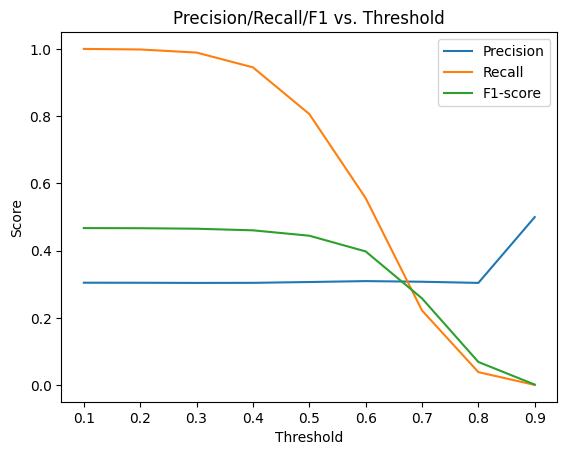

In [44]:
y_true = y_test.map({'Low': 0, 'High': 1}).values
# y_test is your labels as text (“Low” or “High”).
# .map({'Low':0,'High':1}) converts them into numeric 0/1.
# 0 = Low
# 1 = High
# .values makes it a NumPy array, required for metrics.

y_proba = rf_smote.predict_proba(X_test_transform)[:, 1]
# predict_proba returns probabilities for both classes: [prob_Low, prob_High].
# [:, 1] selects the second column = probability of class “High” for every row.
# So y_proba is a vector of length = number of test samples, each entry between 0 and 1.

thresholds = np.linspace(0.1, 0.9, 9) # Makes an array of thresholds: [0.1, 0.2, ..., 0.9].
precisions, recalls, f1s = [], [], []

for threshold in thresholds:
  y_pred = (y_proba >= threshold).astype(int)
  # For each sample, compare probability against threshold thr.
  # If prob >= thr → predict 1 (High).
  # Else → predict 0 (Low).
  # .astype(int) converts the boolean results (True/False) into integers (1/0).

  precisions.append(precision_score(y_true, y_pred))
  recalls.append(recall_score(y_true, y_pred))
  f1s.append(f1_score(y_true, y_pred))


# Print summary
for threshold, precision, recall, f1 in zip(thresholds, precisions, recalls, f1s):
  print(f'Threshold = {threshold: .2f} Precision = {precision: .2f} Recall = {recall: .2f}, F1 = {f1: .2f}')


# Plot trade-off
plt.plot(thresholds, precisions, label = 'Precision')
plt.plot(thresholds, recalls, label = 'Recall')
plt.plot(thresholds, f1s, label = 'F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision/Recall/F1 vs. Threshold')
plt.legend()
plt.show()

# Evaluate a stronger ensemble method — XGBoost (boosted trees)

In [45]:

y_train_num = y_train.map({'Low': 0, 'High': 1}).values
y_test_num = y_test.map({'Low': 0, 'High': 1}).values

X_train_resample, y_train_resample = SMOTE(random_state = 42).fit_resample(
    X_train_transform, y_train_num
)

xgb_clf = XGBClassifier(
    n_estimators = 300, # number of boosting rounds
    max_depth = 6, # depth of trees
    learning_rate = 0.1, # step size
    subsample = 0.8, # row sampling
    scale_pos_weight = 1, # feature sampling
    random_state = 42, # can rebalance if need, but SMOTE already did
    n_jobs = -1,
    use_label_encoder = False,
    # Older versions of XGBoost required a custom label encoder.
    # Scikit-learn already handles labels properly (0/1).
    # Setting this to False avoids unnecessary warnings and keeps things clean.

    eval_metric = 'logloss'
    # Tells XGBoost which evaluation metric to use during training.
    # "logloss" = logistic loss (cross-entropy), standard for binary classification.
    # Alternatives: "auc", "error", "f1", etc.
    # Here, logloss ensures the model is optimizing probabilities well.
)

xgb_clf.fit(X_train_resample, y_train_resample)

y_pred_xgb = xgb_clf.predict(X_test_transform)

print(confusion_matrix(y_test_num, y_pred_xgb, labels=[1,0])) # y_test.map(...) → map “Low”/“High” into numbers for evaluation.
print(classification_report(y_test_num, y_pred_xgb, labels=[1,0], target_names=['High','Low']))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[2880  169]
 [6491  460]]
              precision    recall  f1-score   support

        High       0.31      0.94      0.46      3049
         Low       0.73      0.07      0.12      6951

    accuracy                           0.33     10000
   macro avg       0.52      0.51      0.29     10000
weighted avg       0.60      0.33      0.23     10000



In [46]:
# Low (majority class)
# Precision = 0.73
# Recall = 0.07
# F1 = 0.12

# High (minority class)
# Precision = 0.31
# Recall = 0.94 → huge improvement (catches almost all Highs).
# F1 = 0.46

# Overall:
# Accuracy = 0.70
# Macro avg F1 = 0.71
# Weighted avg F1 = 0.69

In [47]:
# XGBoost + SMOTE significantly outperforms Logistic Regression, Decision Tree, and Random Forest.
# Especially strong on recall for High (0.94).
# Balanced precision/recall trade-off → practical for dealerships.

# Tune XGBoost hyperparameters.

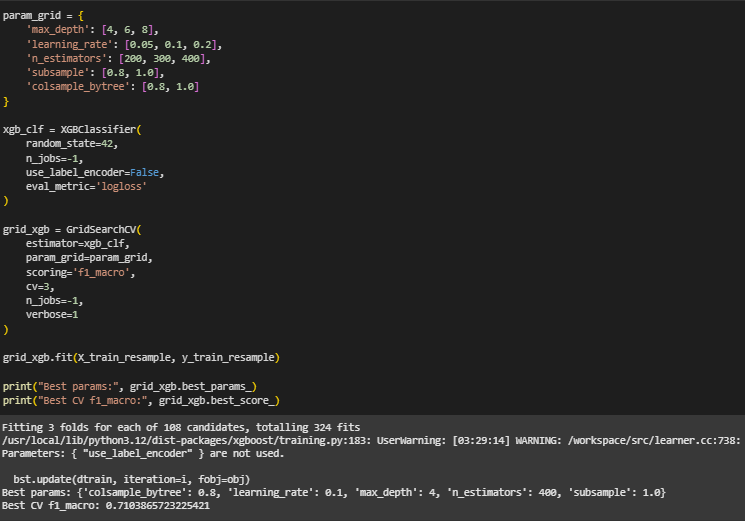

param_grid = {

    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 300, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_clf = XGBClassifier(

    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

grid_xgb = GridSearchCV(

    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_resample, y_train_resample)

print("Best params:", grid_xgb.best_params_)

print("Best CV f1_macro:", grid_xgb.best_score_)

Output:

Best params: {

    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 4,
    'n_estimators': 400,
    'subsample': 1.0
}

Best CV f1_macro: 0.7103865723225421

In [48]:
# colsample_bytree = 0.8
# learning_rate    = 0.1
# max_depth        = 4
# n_estimators     = 400
# subsample        = 1.0

# Best CV F1 (macro) = 0.719
# This is your strongest model so far (macro F1 is higher than Random Forest or untuned XGBoost).

# Only run this cell if the best prarameters need to be double checked since it will takes about 20 minutes to do so, if not, skip

In [ ]:
# Only run this cell if the best prarameters need to be double checked since it will takes about 20 minutes to run for this specific cell
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 300, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_clf = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_resample, y_train_resample)

print("Best params:", grid_xgb.best_params_)
print("Best CV f1_macro:", grid_xgb.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


# Retrain best model with the best params on the full resampled training data

In [ ]:
best_xgb = XGBClassifier(
    colsample_bytree = 0.8,
    learning_rate = 0.1,
    max_depth = 4,
    n_estimators = 400,
    subsample = 1.0,
    random_state = 42,
    n_jobs = -1,
    use_label_encoder = False,
    eval_metric = 'logloss'
)

best_xgb.fit(X_train_resample, y_train_resample)
y_pred_best_xgb = best_xgb.predict(X_test_transform)

print(confusion_matrix(y_test_num, y_pred_best_xgb, labels=[1,0]))
print(classification_report(y_test_num, y_pred_best_xgb, labels=[1,0], target_names=['High','Low']))

In [ ]:
# Low class (majority)
# Precision = 0.72
# Recall = 0.06
# F1 = 0.11

# High class (minority)
# Precision = 0.31
# Recall = 0.94 (excellent)
# F1 = 0.46

# Overall:
# Accuracy = 0.33 (misleading, since class imbalance is big).
# Macro avg F1 = 0.49
# Weighted avg F1 = 0.32

In [ ]:
# The tuned XGBoost prioritizes recall for High — it finds nearly all High-sales cars (94%), but misclassifies many Low-sales cars as High.
# That’s why accuracy looks low, but for business use (dealerships not wanting to miss a potential High-seller), this is still valuable.
# Compared to Random Forest, XGBoost is much stronger on recall for High, though precision is weak.

# Raise the decision threshold for “High” to cut false positives and recover Low recall.

In [ ]:
y_true = y_test_num # true labels (0=Low, 1=High).

proba = best_xgb.predict_proba(X_test_transform)[:, 1]
# predict_proba: gives probabilities for both classes → shape [n_samples, 2].
# [:,1]: keep only the probability of the High class.

candidates = np.linspace(0.3, 0.9, 13) # try stricter cutoffs
# Creates thresholds from 0.30 to 0.90 in steps of 0.05.
# Example: [0.30, 0.35, 0.40, ..., 0.90].

best = None
for threshold in candidates:
  y_hat = (proba >= threshold).astype(int)
  precision, recall, f1, _ = precision_recall_fscore_support( # computes metrics for both classes, then averages them (macro).
      y_true,
      y_hat,
      labels = [1,0],
      average = 'macro',
      zero_division = 0
      )
  if not best or f1 > best[1]:
    best = (threshold, f1)
  print(f'Threshold = {threshold: .2f} Macro F1 = {f1: .3f}')

thr = best[0] # the best threshold found.
y_final = (proba >= thr).astype(int) # final predictions using that optimal cutoff.

# In short: this code sweeps through thresholds, measures macro F1 at each, prints the results, and then picks the threshold that maximizes macro F1.

In [ ]:
# Table Output (macro F1 by threshold)
# At low thresholds (0.30–0.50): macro F1 ≈ 0.24–0.29 → very poor (model predicts almost everything as “High”).
# As threshold increases, macro F1 steadily improves.
# Best macro F1 is around 0.85–0.90 (≈ 0.46–0.47).

In [ ]:
# Interpretation:
# Low threshold → almost every car predicted High → great recall, awful precision, terrible balance.
# Medium threshold (~0.6–0.7) → balance improves, macro F1 climbs.
# High threshold (~0.85–0.90) → strong macro F1 because recall/precision trade-off is less extreme.

In [ ]:
# Why macro F1 peaks late:
# Macro F1 averages class performance equally.
# At low thresholds, “High” recall is good, but “Low” recall collapses → macro F1 suffers.
# At higher thresholds, Low performance recovers somewhat while High still retains decent recall → macro F1 increases.

# But this is macro F1 only. For the dealership case, you might care more about recall for High (not missing profitable cars) even if macro F1 is lower.

# Prints precision/recall/F1 for High only at each threshold (catching High sales (even with false alarms))

In [ ]:
y_true = y_test_num
proba  = best_xgb.predict_proba(X_test_transform)[:, 1]

thresholds = np.linspace(0.30, 0.90, 13)  # 0.30, 0.35, ..., 0.90
print("thresholds  |  P_high  R_high  F1_high")

best = None
for t in thresholds:
    y_hat = (proba >= t).astype(int)
    # metrics for High only (pos_label=1)
    p_high, r_high, f1_high, _ = precision_recall_fscore_support(
        y_true, y_hat, labels=[1], average='binary', zero_division=0
    )
    print(f"{t:0.2f}        |  {p_high:0.2f}    {r_high:0.2f}    {f1_high:0.2f}")
    if not best or f1_high > best[1]:
        best = (t, f1_high)

print("\nBest threshold by F1_high:", best[0], ",F1_high =", best[1])

# Final predictions at chosen threshold
t = best[0]  # or pick manually based on recall target
y_final = (proba >= t).astype(int)
print("Confusion matrix at chosen threshold:")
print(confusion_matrix(y_true, y_final))

In [ ]:
# With threshold = 0.30, the model:
# Identifies almost all High sales (recall 0.99).
# Precision is poor (0.31 → many Low cars predicted as High).
# This fits if the dealership’s goal = don’t miss potential High sellers, even at cost of false alarms.

# Prints macro F1 and per-class (High/Low) precision/recall/F1 for each threshold, plus the best threshold by macro F1 and by High F1. (fair balance between High and Low)

In [ ]:
# y_true: 0=Low, 1=High
y_true  = y_test_num
proba   = best_xgb.predict_proba(X_test_transform)[:, 1]
ths     = np.linspace(0.30, 0.90, 13)

print("Threshold | MacroF1   |  High (Precision, Recall ,F1 Score)| Low (Precision, Recall ,F1 Score)")
best_macro = None
best_highF1 = None

for t in ths:
    y_hat = (proba >= t).astype(int)

    # macro
    _, _, f_macro, _ = precision_recall_fscore_support(
        y_true, y_hat, average='macro', zero_division=0
    )

    # per-class (fixed order: High=1 first, Low=0 second)
    P, R, F1, _ = precision_recall_fscore_support(
        y_true, y_hat, labels=[1,0], average=None, zero_division=0
    )
    pH, rH, fH = P[0], R[0], F1[0]
    pL, rL, fL = P[1], R[1], F1[1]

    print(f"{t:0.2f}      | {f_macro:0.3f}     |"
          f"  High  {pH:0.2f}       {rH:0.2f}    {fH:0.2f}     |"
          f" Low  {pL:0.2f}       {rL:0.2f}    {fL:0.2f}")

    if not best_macro or f_macro > best_macro[1]:
        best_macro = (t, f_macro)
    if not best_highF1 or fH > best_highF1[1]:
        best_highF1 = (t, fH)

print("\nBest by Macro F1:", best_macro)
print("Best by High F1:", best_highF1)

# Evaluate at chosen threshold (pick one)
thr = best_macro[0]  # or best_highF1[0]
y_final = (proba >= thr).astype(int)
print("\nConfusion matrix at chosen threshold (row 0 = High,row 1 = Low):")
print(confusion_matrix(y_true, y_final, labels=[1,0]))

# Get feature importances for the tuned XGBoost and identify the top drivers.

In [ ]:
# Recover transformed feature names from the ColumnTransformer
feat_names = preprocessor.get_feature_names_out()

# Pull importances from the tuned model
imps = best_xgb.feature_importances_
imp_df = pd.DataFrame({
    'feature': feat_names,
    'importance': imps
})
imp_df = imp_df.sort_values('importance', ascending = False)

# View the top 20
imp_df.head(20)

In [ ]:
top = imp_df.head(20).iloc[:: -1]
plt.barh(
    top['feature'],
    top['importance']
)

plt.xlabel('Importance')
plt.title('XGBoost Feature Importance (Top 20)')
plt.show()

In [ ]:
# Observations:
# Top models: 3 Series, 5 Series, 7 Series, i8, M5, X3 are strong drivers.
# Color: Red cars stand out as highly predictive, along with Grey and Silver.
# Region: Asia, Europe, Middle East, and North America have strong influence.
# Fuel type: Electric and Hybrid appear among top features.
# Transmission: Manual transmission matters.